# Лабораторная работа №4 "Восстановление функции распренделения вероятности"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity

In [2]:
# 1. Генерация случайных данных
np.random.seed(42)
data = np.concatenate([
    np.random.normal(-2, 1, 300),
    np.random.normal(3, 0.5, 200),
])

### **1. Основная идея EM-алгоритма**

Прямая максимизация логарифма правдоподобия $ \log P(x | \theta) $ может быть сложной, если скрытые переменные $ z $ не наблюдаются напрямую. Вместо этого EM-алгоритм работает с полной логарифмической правдоподобной функцией $ \log P(x, z | \theta) $ и выполняет итерации в два этапа:

- **E-шаг (Expectation, шаг ожидания):** вычисление ожидания полной правдоподобной функции, усреднённой по распределению скрытых переменных $ z $, условному на текущих параметрах $ \theta^{(t)} $.
- **M-шаг (Maximization, шаг максимизации):** обновление параметров $ \theta $ путём максимизации этого ожидания.

---

### **2. Математическая формулировка**

Правдоподобие для наблюдаемых данных:
$
P(x | \theta) = \int P(x, z | \theta) \, dz.
$

Логарифм правдоподобия:
$
\log P(x | \theta) = \log \int P(x, z | \theta) \, dz.
$

Прямая оптимизация этой функции затруднена из-за сложного интеграла. Вместо этого EM-алгоритм вводит вспомогательную функцию $ Q(\theta, \theta^{(t)}) $:
$
Q(\theta, \theta^{(t)}) = \mathbb{E}_{z \sim P(z | x, \theta^{(t)})} \left[ \log P(x, z | \theta) \right],
$
где $ \theta^{(t)} $ — текущая оценка параметров.

Алгоритм итеративно обновляет $ \theta $, выполняя следующие шаги:

1. **E-шаг:**
   Вычисление $ Q(\theta, \theta^{(t)}) $ как:
   $
   Q(\theta, \theta^{(t)}) = \int P(z | x, \theta^{(t)}) \log P(x, z | \theta) \, dz.
   $

2. **M-шаг:**
   Обновление параметров $ \theta $ путём максимизации $ Q(\theta, \theta^{(t)}) $:
   $
   \theta^{(t+1)} = \arg\max_\theta Q(\theta, \theta^{(t)}).
   $

---

In [7]:
# 1.1 Реализация EM-алгоритма для восстановления плотности вероятности
class EMAlgorithm:
    def __init__(self, n_components, max_iter=100, tol=1e-4):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, data):
        n = len(data)
        self.data = data

        # Инициализация параметров
        self.weights = np.full(self.n_components, 1 / self.n_components)
        self.means = np.random.choice(data, self.n_components)
        self.variances = np.random.random(self.n_components) + 0.1

        log_likelihood = -np.inf

        for iteration in range(self.max_iter):
            # E-шаг: вычисление ответственности
            responsibilities = self._e_step(data)

            # M-шаг: обновление параметров
            self._m_step(data, responsibilities)

            # Проверка сходимости
            new_log_likelihood = self._log_likelihood(data)
            if np.abs(new_log_likelihood - log_likelihood) < self.tol:
                break
            log_likelihood = new_log_likelihood

    def _e_step(self, data):
        likelihoods = np.array([
            self.weights[k] * self._gaussian(data, self.means[k], self.variances[k])
            for k in range(self.n_components)
        ])
        responsibilities = likelihoods / likelihoods.sum(axis=0)
        return responsibilities

    def _m_step(self, data, responsibilities):
        n_k = responsibilities.sum(axis=1)
        self.weights = n_k / len(data)
        self.means = (responsibilities @ data) / n_k
        self.variances = ((responsibilities * (data - self.means[:, np.newaxis]) ** 2).sum(axis=1)) / n_k

    def _log_likelihood(self, data):
        likelihoods = np.array([
            self.weights[k] * self._gaussian(data, self.means[k], self.variances[k])
            for k in range(self.n_components)
        ])
        return np.log(likelihoods.sum(axis=0)).sum()

    @staticmethod
    def _gaussian(x, mean, variance):
        return (1 / np.sqrt(2 * np.pi * variance)) * np.exp(-0.5 * (x - mean) ** 2 / variance)

    def predict_density(self, x):
        density = np.zeros_like(x)
        for k in range(self.n_components):
            density += self.weights[k] * self._gaussian(x, self.means[k], self.variances[k])
        return density

### **1. Идея KDE**

Метод оценки плотности с ядром основан на сглаживании данных: 

- Мы центрируем небольшую "функцию-окно" (ядро) $ K $ на каждом наблюдении $ x_i $.
- Значения функции $ K $ суммируются, чтобы получить итоговую оценку плотности в точке $ x $.

Формула KDE:
$
\hat{f}(x) = \frac{1}{n h} \sum_{i=1}^n K\left(\frac{x - x_i}{h}\right),
$
где:
- $ h > 0 $ — ширина окна или *параметр сглаживания (bandwidth)*;
- $ K(u) $ — ядро, функция с интегралом, равным 1 (обычно симметричная и убывающая от 0).

---

### **2. Компоненты KDE**

#### **2.1. Ядро (Kernel)**

Ядро $ K $ определяет форму функции сглаживания. Оно управляет вкладом каждого наблюдения $ x_i $ в оценку плотности $ \hat{f}(x) $. Наиболее популярные ядра:

1. **Гауссово ядро (Gaussian kernel):**
   $
   K(u) = \frac{1}{\sqrt{2\pi}} e^{-\frac{u^2}{2}}.
   $
   — наиболее часто используемое благодаря гладкости.

2. **Прямоугольное ядро (Uniform kernel):**
   $
   K(u) = \begin{cases} 
   \frac{1}{2}, & |u| \leq 1, \\
   0, & \text{иначе}.
   \end{cases}
   $

3. **Треугольное ядро (Triangular kernel):**
   $
   K(u) = \max(0, 1 - |u|).
   $

4. **Епанечниково ядро (Epanechnikov kernel):**
   $
   K(u) = \frac{3}{4}(1 - u^2), \quad |u| \leq 1.
   $
   — минимизирует дисперсию оценки среди всех ядер.

#### **2.2. Ширина окна (Bandwidth, $ h $)**

Параметр $ h $ определяет степень сглаживания. Он играет ключевую роль:
- **Малое $ h $:** Плотность будет сильно "следовать" за данными, возможно, с шумами (переобучение).
- **Большое $ h $:** Плотность сглаживается, что может потерять важные детали (недообучение).

Выбор $ h $ — одна из главных задач. Методы выбора включают:
- Кросс-валидацию;
- Эвристические подходы (например, *правило серебряной ложки*, Silverman's rule of thumb).

In [8]:
# 1.2 Реализация ядерного сглаживания
class KernelDensityEstimation:
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth

    @staticmethod
    def _kernel(x):
        return np.exp(-0.5 * x ** 2) / np.sqrt(2 * np.pi)

    def fit(self, data):
        self.data = data

    def predict_density(self, x):
        n = len(self.data)
        density = np.zeros_like(x)
        for xi in self.data:
            density += self._kernel((x - xi) / self.bandwidth) / (n * self.bandwidth)
        return density

In [9]:
def generate_data():
    np.random.seed(42)
    data = np.concatenate([
        np.random.normal(loc=-2, scale=0.8, size=100),
        np.random.normal(loc=3, scale=1.2, size=150)
    ])
    return data

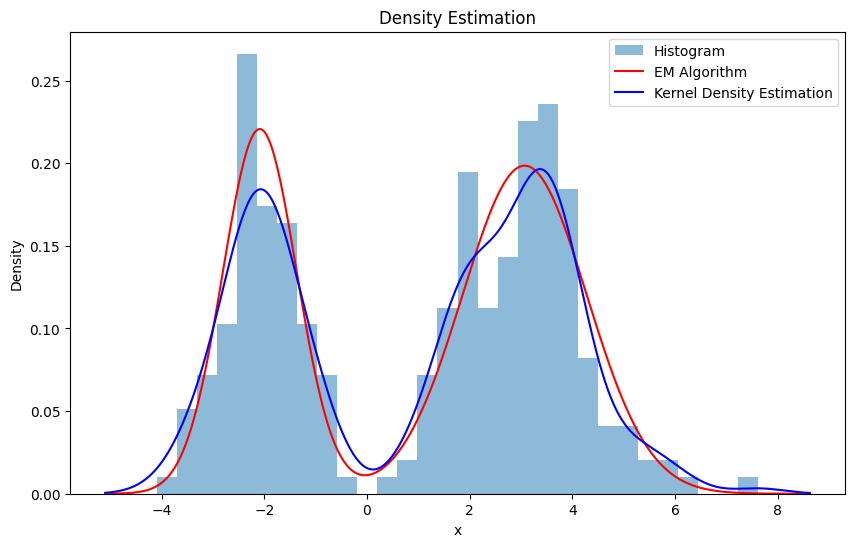

In [10]:
data = generate_data()

# Настройка сетки для оценки плотности
x_grid = np.linspace(min(data) - 1, max(data) + 1, 500)

# 1.1 EM-алгоритм
em = EMAlgorithm(n_components=2)
em.fit(data)
em_density = em.predict_density(x_grid)

# 1.2 Ядерное сглаживание
kde = KernelDensityEstimation(bandwidth=0.5)
kde.fit(data)
kde_density = kde.predict_density(x_grid)

# Визуализация
plt.figure(figsize=(10, 6))

# Гистограмма данных
plt.hist(data, bins=30, density=True, alpha=0.5, label="Histogram")

# Результаты EM-алгоритма
plt.plot(x_grid, em_density, label="EM Algorithm", color="red")

# Результаты ядерного сглаживания
plt.plot(x_grid, kde_density, label="Kernel Density Estimation", color="blue")

plt.title("Density Estimation")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()